# Fraud in Electricity and Gas Consumption

### Related Works

Nagi, J., Yap, K. S., Tiong, S. K., Ahmed, S. K., & Mohamad, M. (2010). Nontechnical loss detection for metered customers in power utility using support vector machines. *IEEE transactions on Power Delivery*, *25*(2), 1162-1171. https://doi.org/10.1109/TPWRD.2009.2030890

Oprea, S. V., & Bâra, A. (2021). Machine learning classification algorithms and anomaly detection in conventional meters and Tunisian electricity consumption large datasets. *Computers & Electrical Engineering*, *94*, 107329. https://doi.org/10.1016/j.compeleceng.2021.107329

Oprea, S. V., & Bâra, A. (2022). Feature engineering solution with structured query language analytic functions in detecting electricity frauds using machine learning. *Scientific Reports*, *12*(1), 3257. https://doi.org/10.1038/s41598-022-07337-7

#### Limitations Identified in the Studies

- Consumption behaviour might usually be aggregated at coarse billing horizons, which suppresses short-lived or seasonal anomalies that inspectors report as key fraud signatures.
- Many pipelines report feature selection on the full dataset prior to the train/test split, introducing a mild but systematic risk of data leakage that may inflate downstream model performance estimates.

#### Our Approach to Overcoming These Limitations

- Incorporate month-level volatility and change features so the models can react to the erratic consumption traces highlighted in Nagi et al. (2010).
- Perform every data-driven transformation (encoding, scaling, feature selection) inside the training folds after splitting, eliminating the leakage pathway noted above.

## Data Preprocessing and Feature Engineering

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import chi2_contingency

import category_encoders as ce
from sklearn.preprocessing import StandardScaler

In [2]:
client = pd.read_csv('../data/client.csv', header = 0)
invoice = pd.read_csv('../data/invoice.csv', header = 0)

client['date'] = pd.to_datetime(client['date'], format = '%d/%m/%Y')
invoice['date'] = pd.to_datetime(invoice['date'], format = '%d/%m/%Y')

client_categorical_cols = ['dis', 'catg', 'region', 'target']
client[client_categorical_cols] = client[client_categorical_cols].astype('category')

invoice_categorical_cols = ['tarif_type', 'counter_statue', 'reading_remarque', 'counter_type']
invoice[invoice_categorical_cols] = invoice[invoice_categorical_cols].astype('category')

In [3]:
# Date-derived columns (invoice/client)
# Ensure invoice and client date fields exist
invoice['invoice_year'] = invoice['date'].dt.year
invoice['invoice_month'] = invoice['date'].dt.month
invoice['invoice_quarter'] = invoice['date'].dt.to_period('Q')

In [4]:
client.head()

,region,date,dis,id,catg,target
0,301,1986-03-13,62,7405,11,0
1,105,1996-07-11,69,4715,11,0
2,303,2014-10-14,62,20199,11,0
3,101,2011-10-25,60,10097,11,0
4,311,2006-06-30,63,20967,12,0


In [5]:
invoice.head()

,id,date,tarif_type,counter_statue,reading_remarque,consommation_level_4,months_number,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,invoice_year,invoice_month,invoice_quarter
0,7405,2010-02-15,11,0,8,0,4,ELEC,1,407,0,0,2010,2,2010Q1
1,7405,2015-03-06,11,0,8,0,8,ELEC,1,815,0,0,2015,3,2015Q1
2,7405,2009-02-13,11,0,6,0,4,ELEC,1,569,0,0,2009,2,2009Q1
3,7405,2019-05-02,11,0,9,0,12,ELEC,1,2400,682,0,2019,5,2019Q2
4,7405,2017-05-30,11,0,8,0,4,ELEC,1,188,0,0,2017,5,2017Q2


In [6]:
client.dtypes

region          category
date      datetime64[ns]
dis             category
id                 int64
catg            category
target          category
dtype: object

In [7]:
invoice.dtypes

id                               int64
date                    datetime64[ns]
tarif_type                    category
counter_statue                category
reading_remarque              category
consommation_level_4             int64
months_number                    int64
counter_type                  category
counter_coefficient              int64
consommation_level_1             int64
consommation_level_2             int64
consommation_level_3             int64
invoice_year                     int32
invoice_month                    int32
invoice_quarter          period[Q-DEC]
dtype: object

In [8]:
invoice.isna().sum()

id                      0
date                    0
tarif_type              0
counter_statue          0
reading_remarque        0
consommation_level_4    0
months_number           0
counter_type            0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
invoice_year            0
invoice_month           0
invoice_quarter         0
dtype: int64

### Feature Extraction

In [9]:
invoice = invoice.sort_values(['id', 'date'])

# Categorical aggregation
categorical_cols = ['tarif_type', 'counter_statue', 'reading_remarque', 'counter_type']

agg_dict = {}
for col in categorical_cols:
    agg_dict[f'mode_{col}'] = (col, lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0])
    agg_dict[f'nunique_{col}'] = (col, 'nunique')

agg_cat = invoice.groupby('id').agg(**agg_dict).reset_index()

In [10]:
# Numerical aggregation
numeric_cols = [
    'consommation_level_1',
    'consommation_level_2',
    'consommation_level_3',
    'consommation_level_4',
    'months_number',
    'counter_coefficient',
]

agg_numeric = invoice.groupby('id')[numeric_cols].agg(['mean', 'median', 'std', 'min', 'max', 'sum']).reset_index()

# Flatten
agg_numeric.columns = ['id'] + [f"{stat}_{col}" for col, stat in agg_numeric.columns[1:]]

In [11]:
# Time-based aggregation
agg_time = invoice.groupby('id').agg(
    first_invoice = ('date', 'min'),
    last_invoice = ('date', 'max'),
    num_invoices = ('date', 'count')
).reset_index()

agg_time['active_days'] = (agg_time['last_invoice'] - agg_time['first_invoice']).dt.days

In [12]:
# Total consumption statistics per customer (comprehensive load profile features)

if 'total_consumption' not in invoice.columns:
    invoice['total_consumption'] = invoice[['consommation_level_1', 'consommation_level_2', 
                                            'consommation_level_3', 'consommation_level_4']].sum(axis=1)

consumption_stats = invoice.groupby('id')['total_consumption'].agg([
    ('consumption_mean', 'mean'),
    ('consumption_std', 'std'),
    ('consumption_max', 'max'),
    ('consumption_min', 'min'),
    ('consumption_sum', 'sum')
]).reset_index()

# Handle NaN in std (single invoice customers)
consumption_stats['consumption_std'] = consumption_stats['consumption_std'].fillna(0)

# Consumption volatility (coefficient of variation)
consumption_stats['consumption_cv'] = consumption_stats['consumption_std'] / (consumption_stats['consumption_mean'] + 1e-6)

# Max to min ratio (demand spread)
consumption_stats['max_min_ratio'] = consumption_stats['consumption_max'] / (consumption_stats['consumption_min'] + 1e-6)

print('Total consumption statistics shape:', consumption_stats.shape)
print('\nColumns:', consumption_stats.columns.tolist())
consumption_stats.head()

Total consumption statistics shape: (11741, 8)

Columns: ['id', 'consumption_mean', 'consumption_std', 'consumption_max', 'consumption_min', 'consumption_sum', 'consumption_cv', 'max_min_ratio']


,id,consumption_mean,consumption_std,consumption_max,consumption_min,consumption_sum,consumption_cv,max_min_ratio
0,1,291.600000,403.890187,1624,5,8748,1.385083,3.247999e+02
1,3,483.214286,282.482954,1002,0,13530,0.584591,1.002000e+09
2,4,1464.750000,657.120233,2944,482,23436,0.448623,6.107884e+00
3,5,729.875000,346.686089,1373,0,17517,0.474994,1.373000e+09
4,7,178.500000,178.785626,362,11,1071,1.001600,3.290909e+01


In [13]:
# Per-month average consumption pivot (month_1 to month_12) 

invoice['total_consumption'] = invoice[['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']].sum(axis=1)

# Compute average consumption per client per month
monthly_avg = (invoice.groupby(['id', 'invoice_month'])['total_consumption']
                .mean()
                .reset_index())

# Pivot to wide format
monthly_pivot = monthly_avg.pivot(index='id', columns='invoice_month', values='total_consumption')

# Renaing columns to month_1...month_12
monthly_pivot = monthly_pivot.rename(columns=lambda m: f'month_{int(m)}')

for m in range(1,13):
    col = f'month_{m}'
    if col not in monthly_pivot.columns:
        monthly_pivot[col] = 0.0

# Reorder columns
monthly_pivot = monthly_pivot[[f'month_{m}' for m in range(1,13)]].reset_index()

# Fill missing with 0
monthly_pivot = monthly_pivot.fillna(0.0)

print('Monthly pivot shape:', monthly_pivot.shape)
monthly_pivot.head()

Monthly pivot shape: (11741, 13)


invoice_month,id,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,0.000,0.0,208.571429,0.0,354.0,0.0,129.000000,0.000000,359.00,142.666667,519.111111,233.666667
1,3,0.000,0.0,451.555556,706.0,0.0,0.0,504.333333,428.000000,0.00,596.000000,455.142857,500.000000
2,4,2829.000,1174.0,0.000000,0.0,0.0,1414.0,0.000000,1214.666667,1248.00,1302.000000,1249.000000,1413.000000
3,5,780.625,0.0,0.000000,0.0,629.8,0.0,661.000000,826.666667,493.25,0.000000,0.000000,1003.000000
4,7,0.000,0.0,0.000000,0.0,0.0,165.5,190.000000,0.000000,180.00,0.000000,0.000000,0.000000


#### Capturing Consumption Trend Volatility

Nagi et al. (2010) emphasise that irregular month-to-month consumption swings often precede confirmed fraud cases even when the annual totals appear normal. To surface those signatures we summarise the per-client monthly series into statistical volatility descriptors (standard deviation, coefficient of variation) and momentum-style change metrics. These aggregates let downstream models reason about sudden spikes, tapering demand, or oscillations without carrying the entire time series, and they complement the categorical consumption context engineered earlier.

In [14]:
# Monthly volatility features
# Standard deviation across months (overall volatility)
monthly_std = monthly_avg.groupby('id')['total_consumption'].std().reset_index()
monthly_std.columns = ['id', 'monthly_consumption_std']

# Mean consumption for normalization
monthly_mean = monthly_avg.groupby('id')['total_consumption'].mean().reset_index()
monthly_mean.columns = ['id', 'monthly_consumption_mean']

# Coefficient of variation (normalized volatility - std/mean)
monthly_volatility = monthly_std.merge(monthly_mean, on='id', how='left')
monthly_volatility['monthly_consumption_cv'] = monthly_volatility['monthly_consumption_std'] / (monthly_volatility['monthly_consumption_mean'] + 1e-6)

# Month-to-month absolute changes (captures zig-zag)
monthly_sorted = monthly_avg.sort_values(['id', 'invoice_month'])
monthly_sorted['consumption_change'] = monthly_sorted.groupby('id')['total_consumption'].diff().abs()

# Average and max month-to-month change per client
monthly_change_stats = monthly_sorted.groupby('id')['consumption_change'].agg(
    avg_monthly_change='mean',
    max_monthly_change='max',
    std_monthly_change='std'
).reset_index()

# Merge all volatility features
monthly_volatility = monthly_volatility.merge(monthly_change_stats, on='id', how='left')
# Drop intermediate columns
monthly_volatility = monthly_volatility.drop(columns=['monthly_consumption_mean'])

print('Monthly volatility features shape:', monthly_volatility.shape)
monthly_volatility.head()

Monthly volatility features shape: (11741, 6)


,id,monthly_consumption_std,monthly_consumption_cv,avg_monthly_change,max_monthly_change,std_monthly_change
0,1,140.103206,0.503964,246.441799,376.444444,77.797390
1,3,98.634327,0.189628,147.693122,254.444444,78.019929
2,4,551.821801,0.372737,342.666667,1655.000000,584.258473
3,5,177.343541,0.242143,238.171667,509.750000,186.111584
4,7,12.318685,0.069012,17.250000,24.500000,10.253048


In [15]:
# Handle NaN values in volatility features 
# For clients with only 1 invoice, std and change metrics will be NaN
# Fill with 0 (no volatility if only 1 data point)
volatility_cols = ['monthly_consumption_std', 'monthly_consumption_cv', 
                'avg_monthly_change', 'max_monthly_change', 'std_monthly_change']
for col in volatility_cols:
    if col in monthly_volatility.columns:
        monthly_volatility[col] = monthly_volatility[col].fillna(0)

print('NaN values in volatility features after filling:')
print(monthly_volatility[volatility_cols].isna().sum())

NaN values in volatility features after filling:
monthly_consumption_std    0
monthly_consumption_cv     0
avg_monthly_change         0
max_monthly_change         0
std_monthly_change         0
dtype: int64


In [16]:
# Merge all invoice-level aggregation
agg_all = agg_numeric.merge(agg_cat, on = 'id', how = 'left')
agg_all = agg_all.merge(agg_time, on = 'id', how = 'left')

# Merge total consumption statistics
if 'consumption_stats' in globals():
    agg_all = agg_all.merge(consumption_stats, on = 'id', how = 'left')

# Merge monthly volatility features (captures trends without raw month values)
if 'monthly_volatility' in globals():
    agg_all = agg_all.merge(monthly_volatility, on = 'id', how = 'left')

# Merge with client dataset
data = client.merge(agg_all, on = 'id', how = 'left')

In [17]:
print('Client dataset:', client.shape)
print('Original invoice dataset:', invoice.shape)
print('Final aggregated invoice dataset:', agg_all.shape)
print('Merged with client dataset:', data.shape)

Client dataset: (11741, 6)
Original invoice dataset: (194374, 16)
Final aggregated invoice dataset: (11741, 61)
Merged with client dataset: (11741, 66)


In [18]:
data.head()

,region,date,dis,id,catg,target,mean_consommation_level_1,median_consommation_level_1,std_consommation_level_1,min_consommation_level_1,...,consumption_max,consumption_min,consumption_sum,consumption_cv,max_min_ratio,monthly_consumption_std,monthly_consumption_cv,avg_monthly_change,max_monthly_change,std_monthly_change
0,301,1986-03-13,62,7405,11,0,798.611111,655.5,513.841374,188,...,3082,188,15057,0.773232,1.639362e+01,251.692147,0.317594,254.700000,419.400000,133.083699
1,105,1996-07-11,69,4715,11,0,1.200000,0.0,3.607011,0,...,15,0,24,3.005840,1.500000e+07,2.992053,2.094436,3.333333,8.000000,3.723797
2,303,2014-10-14,62,20199,11,0,663.714286,770.0,224.831365,124,...,2382,124,12917,0.686599,1.920968e+01,315.385856,0.339411,204.333333,405.500000,127.887711
3,101,2011-10-25,60,10097,11,0,850.800000,800.0,388.977120,254,...,17257,254,38410,0.878792,6.794094e+01,7532.580899,0.860670,12757.500000,14335.000000,2230.921895
4,311,2006-06-30,63,20967,12,0,216.230769,109.0,235.580189,11,...,658,11,2811,1.089485,5.981818e+01,28.480975,0.129839,30.466667,52.866667,31.678384


### Visualisation 1: Fraud Distribution

/var/folders/cp/zf7ldym50k94nmglkp1m5s4w0000gp/T/ipykernel_9850/2852648510.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = data, x = 'target', palette=['#5b9bd5', '#ff6f61'], zorder = 2)


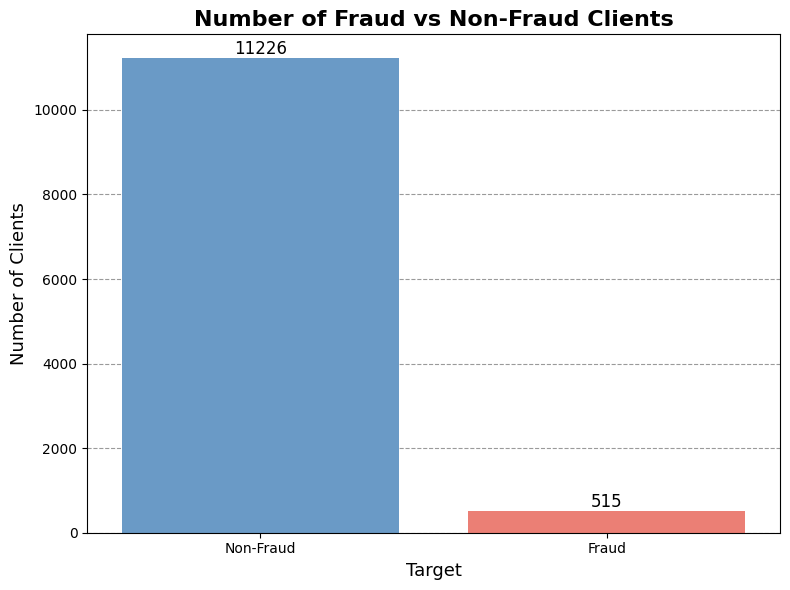

In [19]:
### VISUALISATION 1: FRAUD DISTRIBUTION ###
plt.figure(figsize = (8,6))
sns.countplot(data = data, x = 'target', palette=['#5b9bd5', '#ff6f61'], zorder = 2)
for p in plt.gca().patches:
    height = int(p.get_height())
    plt.gca().annotate(f'{height}', (p.get_x() + p.get_width()/2., height),
                       ha='center', va='bottom', fontsize=12)
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.xlabel('Target', fontsize = 13)
plt.ylabel('Number of Clients', fontsize = 13)
plt.title('Number of Fraud vs Non-Fraud Clients', fontsize = 16, fontweight = 'bold')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7, zorder = 1, color = '#707070')
plt.tight_layout()
plt.show()

### Visualisation 2: Correlation Heatmap of Numeric Features and Target

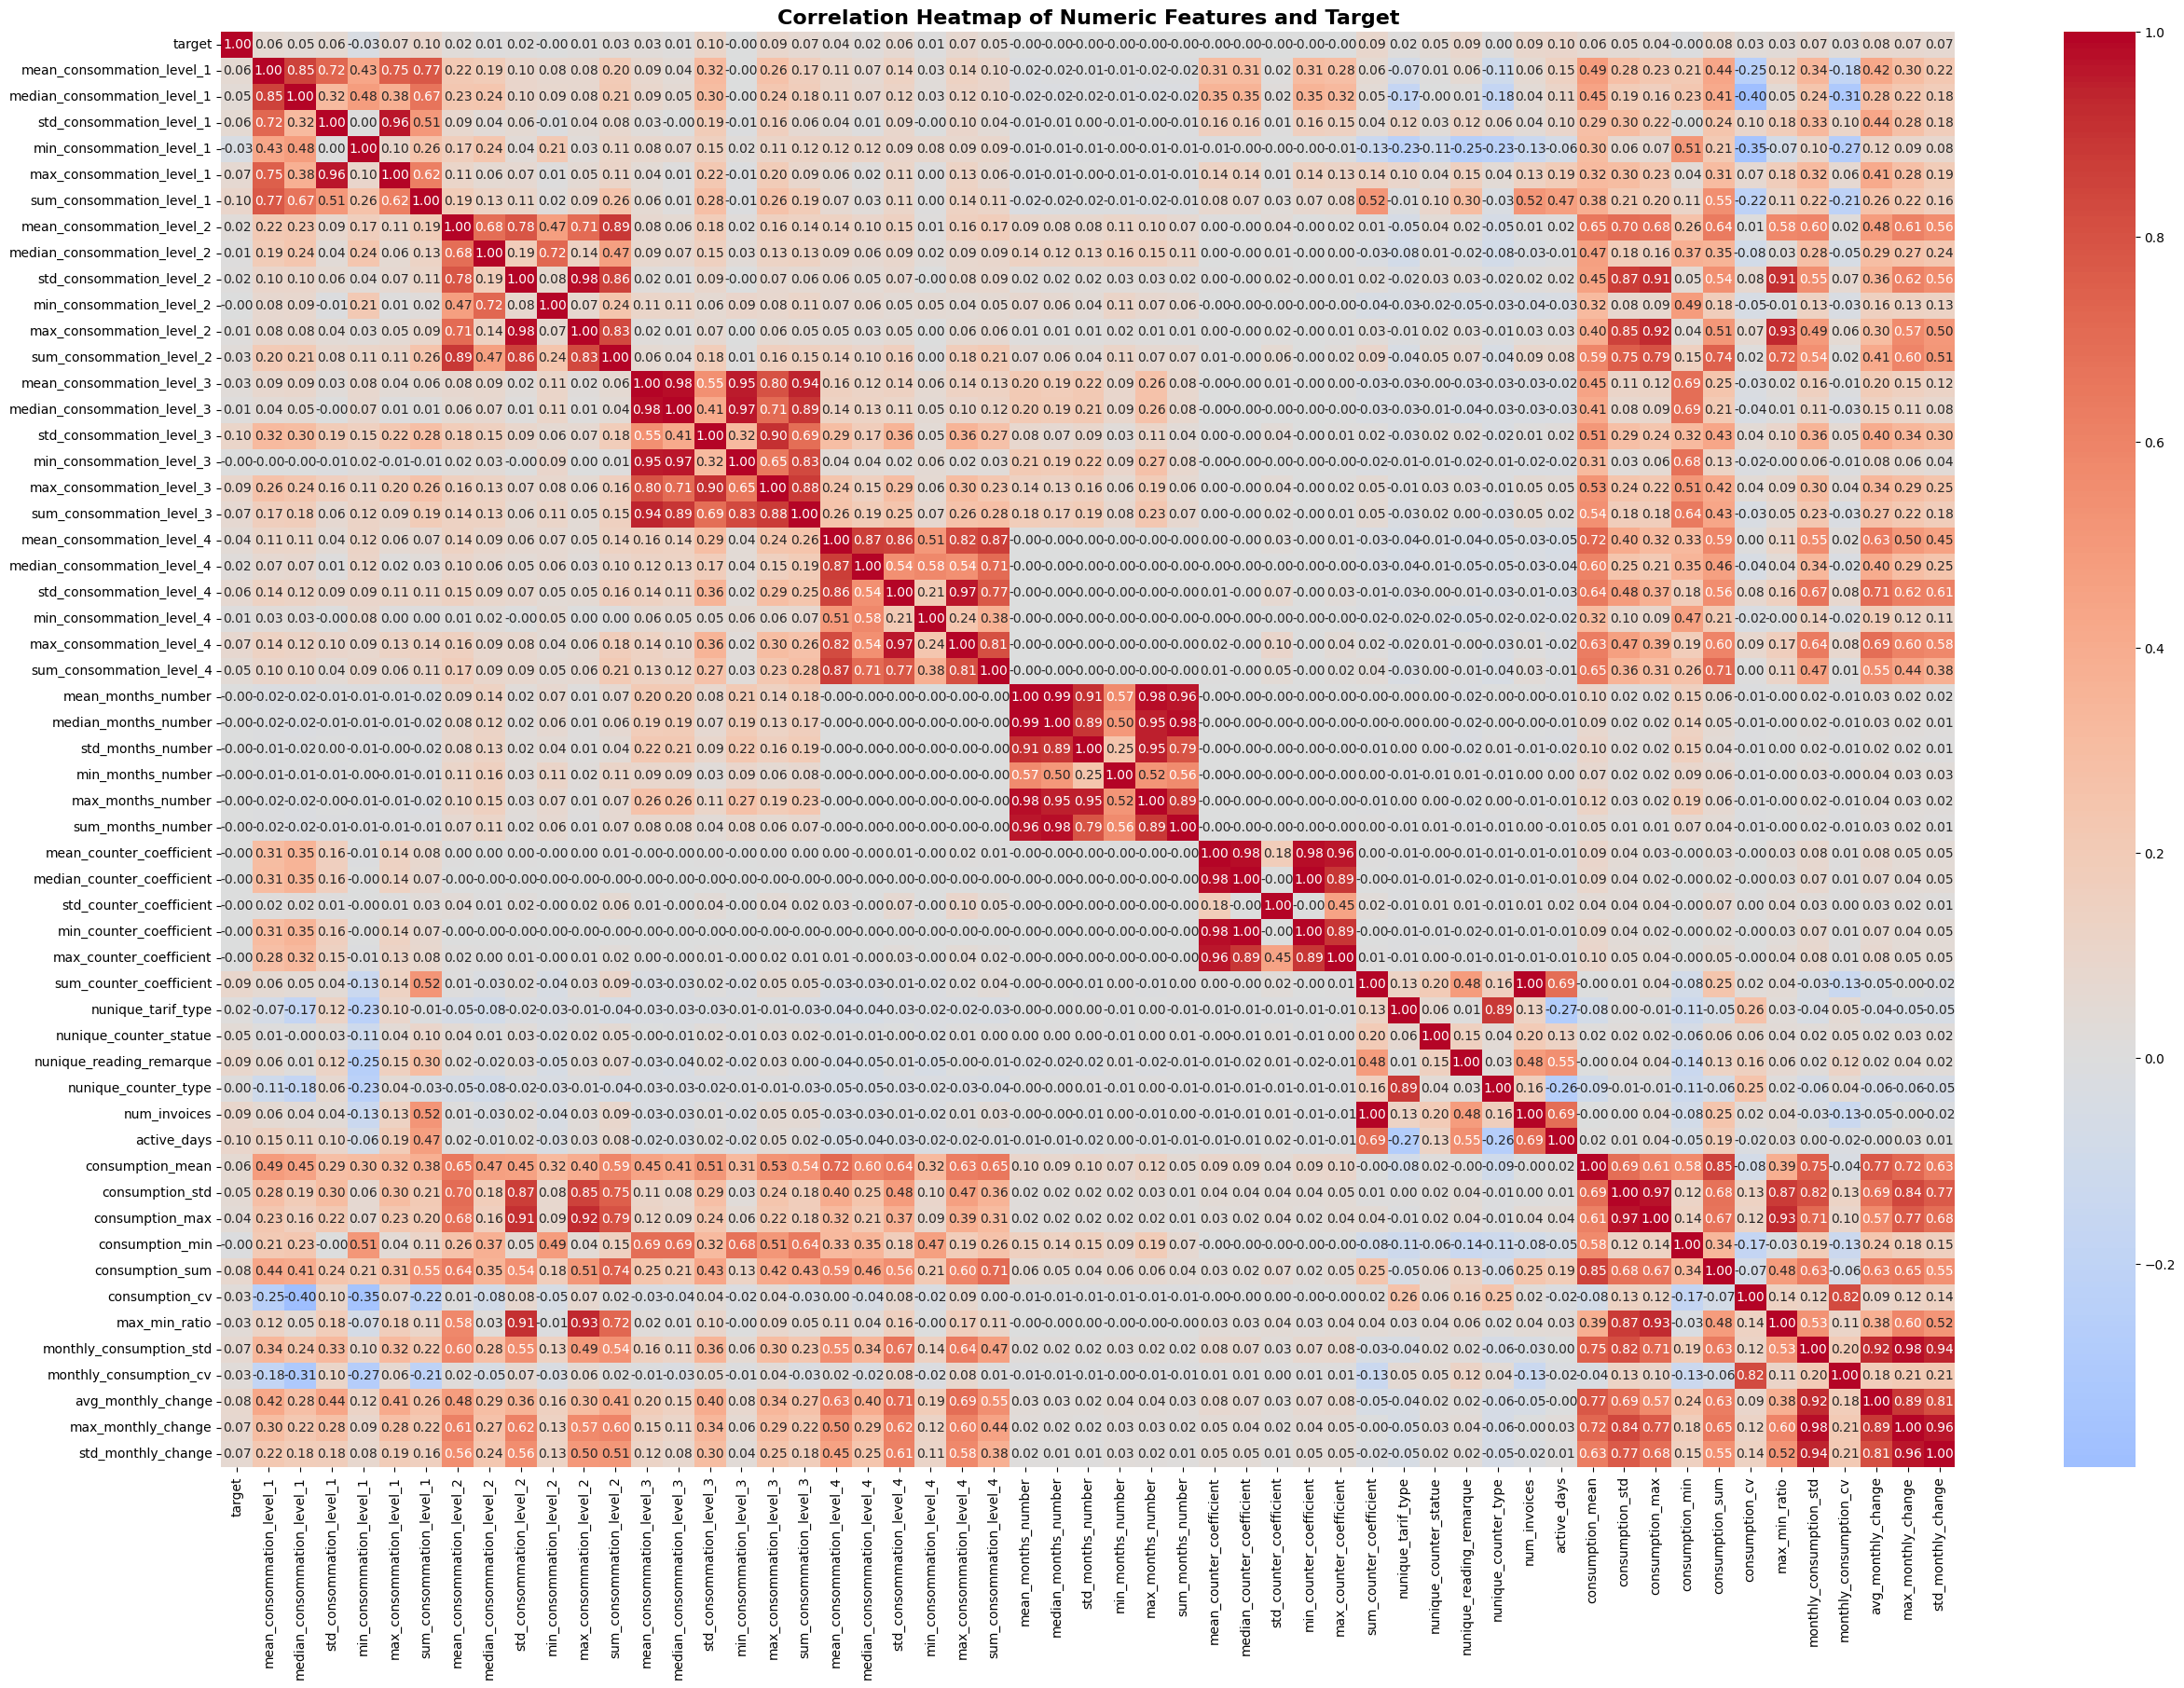

In [20]:
### VISUALISATION 2: CORRELATION HEATMAP OF NUMERIC FEATURES AND TARGET ###
data_temp = data.copy() 
data_temp['target'] = data_temp['target'].astype(int) # converting target to numeric to plot a heatmap
numeric_df = data_temp.select_dtypes(include = 'number').drop(columns = ['id'])
corr = numeric_df.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features and Target', fontsize = 16, fontweight = 'bold')
plt.show()

From the figure above, we can conclude that the numerical features are weakly correlated with `target`

### Train-Test Split

In [21]:
X = data.drop(columns=['target', 'id'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1244, stratify = y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (9392, 64)
Test size: (2349, 64)


### Feature Selection

In [22]:
datetime_features_to_drop = X_train.select_dtypes(include = 'datetime').columns # not necessary after aggregation
X_train = X_train.drop(columns = datetime_features_to_drop)
X_test = X_test.drop(columns = datetime_features_to_drop)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (9392, 61)
Test size: (2349, 61)


#### Fisher Score

As shown in *Visualisation 2: Correlation Heatmap of Numeric Features and Target*, the numeric features are weakly correlated with `target`

Therefore, the Fisher Score is used for feature selection of numeric features, as it captures class variability (how a feature varies between and within classes), which makes it suitable for binary classification problems

Adapted from: https://www.geeksforgeeks.org/machine-learning/fisher-score-for-feature-selection/

In [23]:
# Separate numeric features
numeric_cols = X_train.select_dtypes(include = 'number').columns

# Compute Fisher scores
selector = SelectKBest(score_func = f_classif, k = 'all')
selector.fit(X_train[numeric_cols], y_train)
scores = selector.scores_

# Display results
fisher_df = pd.DataFrame({
    'feature': numeric_cols,
    'fisher score': scores
}).sort_values(by = 'fisher score', ascending = False)
fisher_df

/Users/annchi/Desktop/IT1244_Team18_Project/code/venv-it1244/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/annchi/Desktop/IT1244_Team18_Project/code/venv-it1244/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,feature,fisher score
14,std_consommation_level_3,104.920358
5,sum_consommation_level_1,83.249658
41,active_days,77.403634
16,max_consommation_level_3,75.867048
38,nunique_reading_remarque,71.376693
51,avg_monthly_change,69.053931
40,num_invoices,67.935284
35,sum_counter_coefficient,67.903761
22,max_consommation_level_4,61.251052
46,consumption_sum,55.011730


##### Visualisation 3: Fisher Score

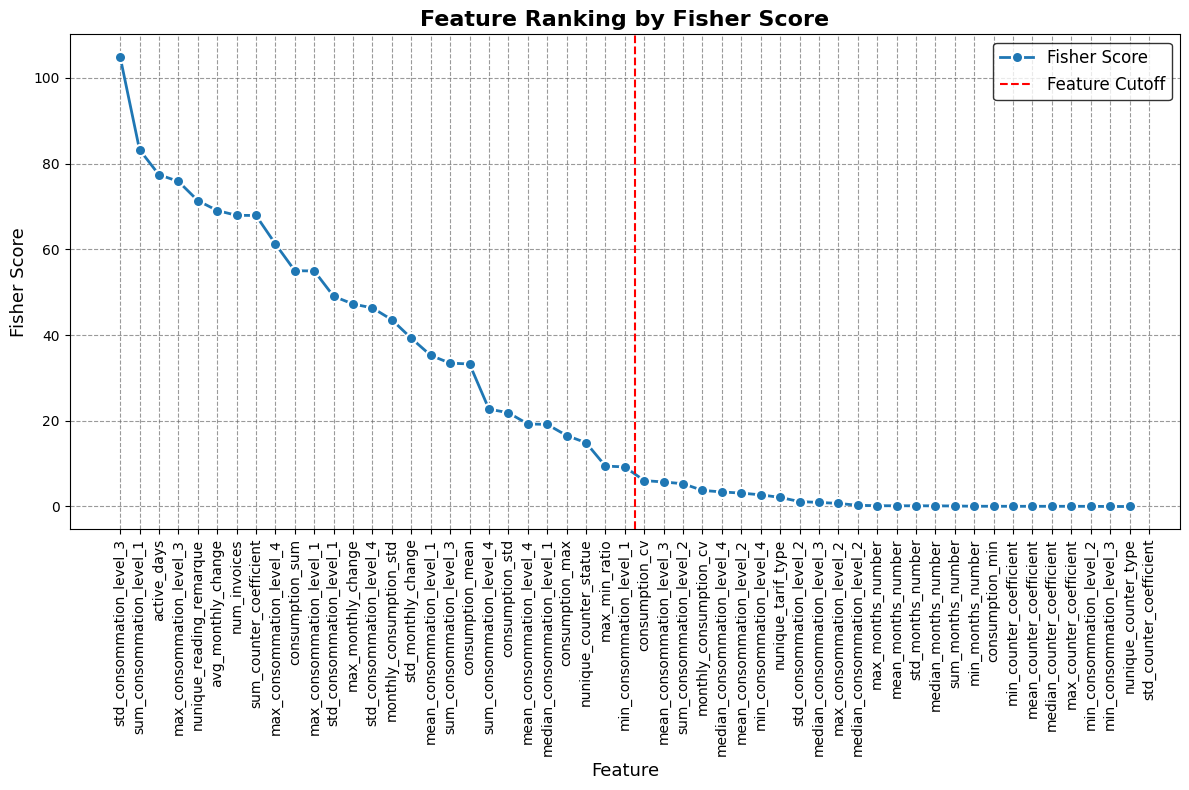

In [24]:
### VISUALIATION 3: FISHER SCORE ###
cutoff_index = fisher_df['feature'].tolist().index('consumption_cv')

plt.figure(figsize = (12,8))
plt.plot(fisher_df['fisher score'].values, 
         marker = 'o',
         color='#1f77b4', 
         linewidth = 2, 
         markersize = 8, 
         markerfacecolor = '#1f77b4',
         markeredgewidth = 1.5,
         markeredgecolor = 'white',
         label = 'Fisher Score')
plt.xticks(range(len(fisher_df)), fisher_df['feature'], rotation = 90)
plt.ylabel('Fisher Score', fontsize = 13)
plt.xlabel('Feature', fontsize = 13)
plt.title('Feature Ranking by Fisher Score', fontsize = 16, fontweight = 'bold')
plt.axvline(x = cutoff_index - 0.5, linestyle='--', label='Feature Cutoff', color='red')
plt.legend(loc = 'upper right', fontsize = 12, frameon = True, facecolor = "white", edgecolor = 'black')
plt.grid(linestyle = '--', alpha = 0.7, zorder = 1, color='#707070')
plt.tight_layout()
plt.show()

Using the elbow method, we can see that the scores start to flatten at around `consumption_cv`. Therefore, we will drop all features from `consumption_cv` (inclusive) onwards

In [25]:
threshold = fisher_df.loc[fisher_df['feature'] == 'consumption_cv', 'fisher score'].values[0]
numeric_features_to_drop = fisher_df[(fisher_df['fisher score'] <= threshold) | (fisher_df['fisher score'].isna())]['feature'].tolist()
len(numeric_features_to_drop)

X_train = X_train.drop(columns = numeric_features_to_drop)
X_test = X_test.drop(columns = numeric_features_to_drop)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (9392, 34)
Test size: (2349, 34)


#### Chi-Square Test

Chi-Square test was applied to categorical features to assess their association with the fraud feature. Features with p-values greater than or equal to 0.05 were considered to be independent of the target and thus excluded from further analysis

Adapted from: https://www.geeksforgeeks.org/python/python-pearsons-chi-square-test/

In [26]:
# Separate categorical features
categorical_cols = X_train.select_dtypes(include = 'category').columns
chi2_results = {}

# Compute chi-square
for col in categorical_cols:
    contingency_table = pd.crosstab(X_train[col], y_train)
    chi2_stat, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results[col] = p

# Display results
chi2_df = pd.DataFrame(list(chi2_results.items()), columns = ['feature', 'p_value'])
chi2_df = chi2_df.sort_values('p_value')
chi2_df

,feature,p_value
2,catg,4.651536e-13
0,region,3.902229e-09
1,dis,1.175914e-06
5,mode_reading_remarque,2.260726e-04
3,mode_tarif_type,1.001676e-02
6,mode_counter_type,1.190764e-01
4,mode_counter_statue,9.278956e-01


In [27]:
categorical_features_to_drop = chi2_df[chi2_df['p_value'] >= 0.05]['feature'].tolist()

X_train = X_train.drop(columns = categorical_features_to_drop)
X_test = X_test.drop(columns = categorical_features_to_drop)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (9392, 32)
Test size: (2349, 32)


### Building the Encoder

We build and save the encoders so they can be reused later during model building or evaluation. Copies of the training and testing datasets are used to ensure that the original datasets remain unmodified

In [28]:
categorical_cols = X_train.select_dtypes(include = 'category').columns
X_train[categorical_cols].nunique()

region                   24
dis                       4
catg                      3
mode_tarif_type           9
mode_reading_remarque     3
dtype: int64

Based on the number of unique categorical features, `region` is a high-cardinality feature, `mode_tarif_type` is a medium-cardinality feature and the remaining features (`dis`, `catg`, `mode_reading_remarque`) are low-cardinality features

Therefore, we will use target encoder for `region` and `mode_tarif_type`, while one-hot encoder for `dis`, `catg` and `mode_reading_remarque`

Adapted from: https://www.geeksforgeeks.org/machine-learning/how-to-fit-categorical-data-types-for-random-forest-classification/

In [29]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

#### Target Encoder

In [30]:
target_encoder = ce.TargetEncoder(cols=['region', 'mode_tarif_type'], smoothing=10) # smoothing helps to prevent overfitting
target_encoder.fit(X_train_enc, y_train)
X_train_enc = target_encoder.transform(X_train_enc)
X_test_enc = target_encoder.transform(X_test_enc) 

#### One-Hot Encoder

In [31]:
one_hot_encoder = ce.OneHotEncoder(cols=['dis', 'catg', 'mode_reading_remarque'])
one_hot_encoder.fit(X_train_enc, y_train)
X_train_enc = one_hot_encoder.transform(X_train_enc)
X_test_enc = one_hot_encoder.transform(X_test_enc)

In [32]:
print('Train size:', X_train.shape)
print('Test size:', X_test.shape)
print('Encoded train size:', X_train_enc.shape)
print('Encoded test size:', X_test_enc.shape)

Train size: (9392, 32)
Test size: (2349, 32)
Encoded train size: (9392, 39)
Encoded test size: (2349, 39)


### Building the Scaler

We build and save the scaler so they can be reused later during model building or evaluation

`StandardScaler` is selected because they do not distort values and is ideal for logistic regression and SVM, which are two models that we will be building

In [33]:
scaler = StandardScaler()
scaler.fit_transform(X_train_enc)
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

print('Scaled train size:', X_train_scaled.shape)
print('Scaled test size:', X_test_scaled.shape)

Scaled train size: (9392, 39)
Scaled test size: (2349, 39)


### Saving Datasets, Encoders and Scaler

In [34]:
joblib.dump(X_train, '../data/X_train.pkl')
joblib.dump(y_train, '../data/y_train.pkl')
joblib.dump(X_test, '../data/X_test.pkl')
joblib.dump(y_test, '../data/y_test.pkl')

['../data/y_test.pkl']

In [35]:
joblib.dump(target_encoder, '../data/target_encoder.pkl')
joblib.dump(one_hot_encoder, '../data/one_hot_encoder.pkl')

['../data/one_hot_encoder.pkl']

In [36]:
joblib.dump(scaler, '../data/scaler.pkl')

['../data/scaler.pkl']